In [1]:
import pandas as pd
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
%matplotlib inline

font_dirs = ['./font'] # 폰트경로
font_files = fm.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    fm.fontManager.addfont(font_file)
plt.rcParams['font.family'] = 'Noto Sans CJK KR'
%config InlineBackend.figure_format = 'retina'

In [2]:
from glob import glob

In [3]:
full_files = glob('./data/*_full.xlsx')
num_files = glob('./data/*_number.xlsx')

In [4]:
full_files = sorted(full_files)

In [5]:
num_files = sorted(num_files)

In [6]:
sido_list = ['서울', '부산', '대구', '인천', '광주', '대전', '울산', '세종', '경기',
               '강원', '충북', '충남', '전북', '전남', '경북', '경남', '제주']

In [7]:
def calculate_rate(d):
    full, number =d['입학정원'],d['입학자수']
    if full==0:
        return -1
    return number/full
def create_new_index(d):
    sido, sigungu = d['시도'],d['행정구']
    return str(sido)+'|' + str(sigungu)
def split_hjgu(d):
    d = d['행정구역']
    if type(d) == float:
        return None
    return d.split()[-1]

def split_hjgu_new(d):
    d = d['행정구']
    if type(d) == float:
        return None
    return d.split()[-1]

def fill_hyphen(d):
    if d == '-':
        return 0
    return d

In [8]:
result = []
for i in range(len(num_files)):
    year = num_files[i].split('/')[-1].split('_')[0]
    df_number = pd.read_excel(num_files[i])
    df_full = pd.read_excel(full_files[i])

    if '행정구' not in df_number.columns:
        df_number['행정구'] = df_number.apply(split_hjgu, axis=1)
    if '행정구'  not in df_full.columns:
        df_full['행정구'] = df_full.apply(split_hjgu, axis=1)

    df_number['행정구역'] = df_number['행정구']
    df_full['행정구역'] = df_full['행정구']
    df_number = df_number.applymap(fill_hyphen)
    df_full = df_full.applymap(fill_hyphen)
    if '입학정원' not in df_full.columns:
        df_full['입학정원'] = df_full['전체']
        df_number['입학자수'] = df_number['전체']
    df_list = list()
    df_full['rename_index']= df_full.apply(create_new_index,axis=1)
    df_number['rename_index']= df_number.apply(create_new_index,axis=1)
    
    df1=df_full[['rename_index','시도','행정구역','입학정원']]
    df2=df_number[['rename_index','시도','행정구역','입학자수']]
    print(df1.columns,df2.columns)
    for isido in sido_list:
        tmp_df=pd.merge(df1[(df1['시도']==isido)\
                            
                            &(df1['행정구역']!='총계')\
                            &(df1['행정구역']!='행정구역')][['시도','행정구역','입학정원']], 
                        df2[(df2['시도']==isido)\
                            
                            &(df2['행정구역']!='총계')\
                            &(df2['행정구역']!='행정구역')][['시도','행정구역','입학자수']], 
                        how='outer', on=None)
        
        tmp_df.columns=['시도','행정구','입학정원','입학자수']
        tmp_df['index'] = tmp_df.apply(create_new_index, axis=1)
        
        tmp_df = tmp_df.set_index('index')
        df_list.append(tmp_df)
        
    df=pd.DataFrame()
    for idf in df_list:
        df = df.append(idf)
    df[year+'|rate']=df.apply(calculate_rate,axis=1)
    df.columns=['시도','행정구역',year+'|입학정원',year+'|입학자수',year+'|rate']
    df = df[['시도',year+'|입학정원',year+'|입학자수',year+'|rate']]
    result.append(df)

/Users/jmchoi/opt/anaconda3/envs/soprise/lib/python3.7/site-packages/openpyxl/styles/stylesheet.py:221: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Index(['rename_index', '시도', '행정구역', '입학정원'], dtype='object') Index(['rename_index', '시도', '행정구역', '입학자수'], dtype='object')
Index(['rename_index', '시도', '행정구역', '입학정원'], dtype='object') Index(['rename_index', '시도', '행정구역', '입학자수'], dtype='object')
Index(['rename_index', '시도', '행정구역', '입학정원'], dtype='object') Index(['rename_index', '시도', '행정구역', '입학자수'], dtype='object')
Index(['rename_index', '시도', '행정구역', '입학정원'], dtype='object') Index(['rename_index', '시도', '행정구역', '입학자수'], dtype='object')
Index(['rename_index', '시도', '행정구역', '입학정원'], dtype='object') Index(['rename_index', '시도', '행정구역', '입학자수'], dtype='object')


In [9]:
result[0].iloc[20:30]

,시도,2016|입학정원,2016|입학자수,2016|rate
index,,,,
서울|영등포구,서울,180,90,0.500000
서울|용산구,서울,4223,4288,1.015392
서울|은평구,서울,268,221,0.824627
서울|종로구,서울,75816,36718,0.484304
서울|중구,서울,7148,7750,1.084219
서울|중랑구,서울,2606,3019,1.158480
부산|계,부산,54476,58479,1.073482
부산|금정구,부산,11088,11709,1.056006
부산|남구,부산,10204,10834,1.061740


In [10]:
def filter_total_data(d):
    d=d['index']
    first, second = d.split('|')
    if first =="세종" and second=="계":
        return True
    elif second=="계":
        return False
    else:
        return True
df = result[0].reset_index()
df['filter']=df.apply(filter_total_data, axis=1)

In [11]:
df[df['filter']==True].iloc[60:70]

,index,시도,2016|입학정원,2016|입학자수,2016|rate,filter
67,울산|동구,울산,1800,2042,1.134444,True
68,울산|울주군,울산,1771,1868,1.054771,True
69,울산|중구,울산,405,484,1.195062,True
70,세종|계,세종,4832,5383,1.114031,True
71,세종|세종,세종,4832,5383,1.114031,True
73,경기|가평군,경기,38,36,0.947368,True
74,경기|고양시,경기,1384,1487,1.074422,True
75,경기|과천시,경기,40,15,0.375000,True
76,경기|광주시,경기,3396,2973,0.875442,True
77,경기|군포시,경기,953,1002,1.051417,True


In [12]:
df1=pd.merge(left = result[0] , right = result[1], how = "outer", on = 'index')
df2=pd.merge(left = result[2] , right = result[3], how = "outer", on = 'index')
df3 = pd.merge(left = df1, right=df2, how="outer", on="index")
final_df = pd.merge(left = df3, right=result[4], how="outer", on="index")

In [13]:
final_df

,시도_x_x,2016|입학정원,2016|입학자수,2016|rate,시도_y_x,2017|입학정원,2017|입학자수,2017|rate,시도_x_y,2018|입학정원,2018|입학자수,2018|rate,시도_y_y,2019|입학정원,2019|입학자수,2019|rate,시도,2020|입학정원,2020|입학자수,2020|rate
index,,,,,,,,,,,,,,,,,,,,
서울|계,서울,233203,207113,0.888123,서울,232436,202310,0.870390,서울,230041,202833,0.881725,서울,227869,202194,0.887326,서울,NaN,204510,NaN
서울|강남구,서울,440,457,1.038636,서울,449,456,1.015590,서울,449,439,0.977728,서울,554,619,1.117329,서울,554,598,1.079422
서울|강동구,서울,50,48,0.960000,서울,50,86,1.720000,서울,50,20,0.400000,서울,50,35,0.700000,서울,50,27,0.540000
서울|강북구,서울,3621,3474,0.959403,서울,3561,2843,0.798371,서울,3561,3341,0.938220,서울,3561,3278,0.920528,서울,3561,4204,1.180567
서울|강서구,서울,742,831,1.119946,서울,734,850,1.158038,서울,3701,3214,0.868414,서울,3701,3055,0.825453,서울,3701,2684,0.725209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
전북|nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,전북,27696,NaN,NaN
전남|nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,전남,17598,NaN,NaN
경북|nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,경북,44518,NaN,NaN


In [14]:
final_df =final_df.reset_index()

In [15]:
def filter_total_data(d):
    d=d['index']
    first, second = d.split('|')
    if first =="세종" and second=="계":
        return True
    elif second=="계":
        return None
    elif second=='nan':
        return None
    else:
        return True
final_df['filter'] = final_df.apply(filter_total_data,axis=1)

In [16]:
df = final_df[final_df['filter']==True]

In [28]:
df.head()

,index,시도,2016|입학정원,2016|입학자수,2016|rate,2017|입학정원,2017|입학자수,2017|rate,2018|입학정원,2018|입학자수,2018|rate,2019|입학정원,2019|입학자수,2019|rate,2020|입학정원,2020|입학자수,2020|rate
0,서울|강남구,서울,440,457,1.038636,449,456,1.015590,449,439,0.977728,554,619,1.117329,554,598,1.079422
1,서울|강동구,서울,50,48,0.960000,50,86,1.720000,50,20,0.400000,50,35,0.700000,50,27,0.540000
2,서울|강북구,서울,3621,3474,0.959403,3561,2843,0.798371,3561,3341,0.938220,3561,3278,0.920528,3561,4204,1.180567
3,서울|강서구,서울,742,831,1.119946,734,850,1.158038,3701,3214,0.868414,3701,3055,0.825453,3701,2684,0.725209
4,서울|관악구,서울,8453,8729,1.032651,8447,8612,1.019534,8491,8494,1.000353,8471,8343,0.984890,8457,8541,1.009933


In [18]:
df=df[['index','시도_x_x',
    '2016|입학정원','2016|입학자수','2016|rate',
    '2017|입학정원','2017|입학자수','2017|rate',
    '2018|입학정원','2018|입학자수','2018|rate',
    '2019|입학정원','2019|입학자수','2019|rate',
    '2020|입학정원','2020|입학자수','2020|rate', 'filter'
   ]]
df = df.set_index('index')

In [19]:
df.columns=['시도']+df.columns[1:].tolist()
df[df.columns[:-1]].head()

,시도,2016|입학정원,2016|입학자수,2016|rate,2017|입학정원,2017|입학자수,2017|rate,2018|입학정원,2018|입학자수,2018|rate,2019|입학정원,2019|입학자수,2019|rate,2020|입학정원,2020|입학자수,2020|rate
index,,,,,,,,,,,,,,,,
서울|강남구,서울,440,457,1.038636,449,456,1.015590,449,439,0.977728,554,619,1.117329,554,598,1.079422
서울|강동구,서울,50,48,0.960000,50,86,1.720000,50,20,0.400000,50,35,0.700000,50,27,0.540000
서울|강북구,서울,3621,3474,0.959403,3561,2843,0.798371,3561,3341,0.938220,3561,3278,0.920528,3561,4204,1.180567
서울|강서구,서울,742,831,1.119946,734,850,1.158038,3701,3214,0.868414,3701,3055,0.825453,3701,2684,0.725209
서울|관악구,서울,8453,8729,1.032651,8447,8612,1.019534,8491,8494,1.000353,8471,8343,0.984890,8457,8541,1.009933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
경남|양산시,경남,2051,2175,1.060458,1873,1939,1.035238,1716,1926,1.122378,1649,1832,1.110976,1620,1835,1.132716
경남|진주시,경남,8501,8953,1.053170,8224,8593,1.044869,8135,8521,1.047449,8084,8080,0.999505,7870,7861,0.998856
경남|창원시,경남,11307,11673,1.032369,11014,11384,1.033594,10824,11006,1.016814,10740,10967,1.021136,10540,10519,0.998008


In [20]:
df.iloc[63:69]

,시도,2016|입학정원,2016|입학자수,2016|rate,2017|입학정원,2017|입학자수,2017|rate,2018|입학정원,2018|입학자수,2018|rate,2019|입학정원,2019|입학자수,2019|rate,2020|입학정원,2020|입학자수,2020|rate,filter
index,,,,,,,,,,,,,,,,,
세종|계,세종,4832,5383,1.114031,4762,5290,1.110878,4603,5119,1.112101,4603,5177,1.124701,NaN,5141,NaN,True
세종|계,세종,4832,5383,1.114031,4762,5290,1.110878,4603,5119,1.112101,4603,5177,1.124701,NaN,5141,NaN,True
세종|계,세종,4832,5383,1.114031,4762,5290,1.110878,4603,5119,1.112101,4603,5177,1.124701,NaN,5141,NaN,True
세종|계,세종,4832,5383,1.114031,4762,5290,1.110878,4603,5119,1.112101,4603,5177,1.124701,NaN,5141,NaN,True
세종|세종,세종,4832,5383,1.114031,4762,5290,1.110878,NaN,NaN,NaN,NaN,NaN,NaN,4588,5141,1.120532,True
경기|가평군,경기,38,36,0.947368,38,35,0.921053,38,23,0.605263,38,25,0.657895,38,32,0.842105,True


In [21]:
df.loc['세종|세종','2018|입학정원':'2019|rate'] = [4603,5119,1.112101,4603,5177,1.124701]

In [22]:
df.iloc[63:69]

,시도,2016|입학정원,2016|입학자수,2016|rate,2017|입학정원,2017|입학자수,2017|rate,2018|입학정원,2018|입학자수,2018|rate,2019|입학정원,2019|입학자수,2019|rate,2020|입학정원,2020|입학자수,2020|rate,filter
index,,,,,,,,,,,,,,,,,
세종|계,세종,4832,5383,1.114031,4762,5290,1.110878,4603,5119,1.112101,4603,5177,1.124701,NaN,5141,NaN,True
세종|계,세종,4832,5383,1.114031,4762,5290,1.110878,4603,5119,1.112101,4603,5177,1.124701,NaN,5141,NaN,True
세종|계,세종,4832,5383,1.114031,4762,5290,1.110878,4603,5119,1.112101,4603,5177,1.124701,NaN,5141,NaN,True
세종|계,세종,4832,5383,1.114031,4762,5290,1.110878,4603,5119,1.112101,4603,5177,1.124701,NaN,5141,NaN,True
세종|세종,세종,4832,5383,1.114031,4762,5290,1.110878,4603,5119,1.112101,4603,5177,1.124701,4588,5141,1.120532,True
경기|가평군,경기,38,36,0.947368,38,35,0.921053,38,23,0.605263,38,25,0.657895,38,32,0.842105,True


In [23]:
df = df.drop(['세종|계']) # 필요없는 데이터 제거

In [24]:
df.iloc[60:65]

,시도,2016|입학정원,2016|입학자수,2016|rate,2017|입학정원,2017|입학자수,2017|rate,2018|입학정원,2018|입학자수,2018|rate,2019|입학정원,2019|입학자수,2019|rate,2020|입학정원,2020|입학자수,2020|rate,filter
index,,,,,,,,,,,,,,,,,
울산|동구,울산,1800,2042,1.134444,1768,2009,1.136312,1763,2041,1.157686,1803,2181,1.209651,1743,2237,1.283419,True
울산|울주군,울산,1771,1868,1.054771,1755,1880,1.071225,1755,1823,1.038746,1755,1875,1.068376,1663,1765,1.061335,True
울산|중구,울산,405,484,1.195062,405,476,1.175309,405,475,1.172840,355,401,1.129577,325,377,1.160000,True
세종|세종,세종,4832,5383,1.114031,4762,5290,1.110878,4603,5119,1.112101,4603,5177,1.124701,4588,5141,1.120532,True
경기|가평군,경기,38,36,0.947368,38,35,0.921053,38,23,0.605263,38,25,0.657895,38,32,0.842105,True


In [25]:
df = df[df.columns[0:-1]].reset_index()
df.head()

,index,시도,2016|입학정원,2016|입학자수,2016|rate,2017|입학정원,2017|입학자수,2017|rate,2018|입학정원,2018|입학자수,2018|rate,2019|입학정원,2019|입학자수,2019|rate,2020|입학정원,2020|입학자수,2020|rate
0,서울|강남구,서울,440,457,1.038636,449,456,1.015590,449,439,0.977728,554,619,1.117329,554,598,1.079422
1,서울|강동구,서울,50,48,0.960000,50,86,1.720000,50,20,0.400000,50,35,0.700000,50,27,0.540000
2,서울|강북구,서울,3621,3474,0.959403,3561,2843,0.798371,3561,3341,0.938220,3561,3278,0.920528,3561,4204,1.180567
3,서울|강서구,서울,742,831,1.119946,734,850,1.158038,3701,3214,0.868414,3701,3055,0.825453,3701,2684,0.725209
4,서울|관악구,서울,8453,8729,1.032651,8447,8612,1.019534,8491,8494,1.000353,8471,8343,0.984890,8457,8541,1.009933


In [26]:
df.to_json('./data/data.json', orient='records',force_ascii=False)


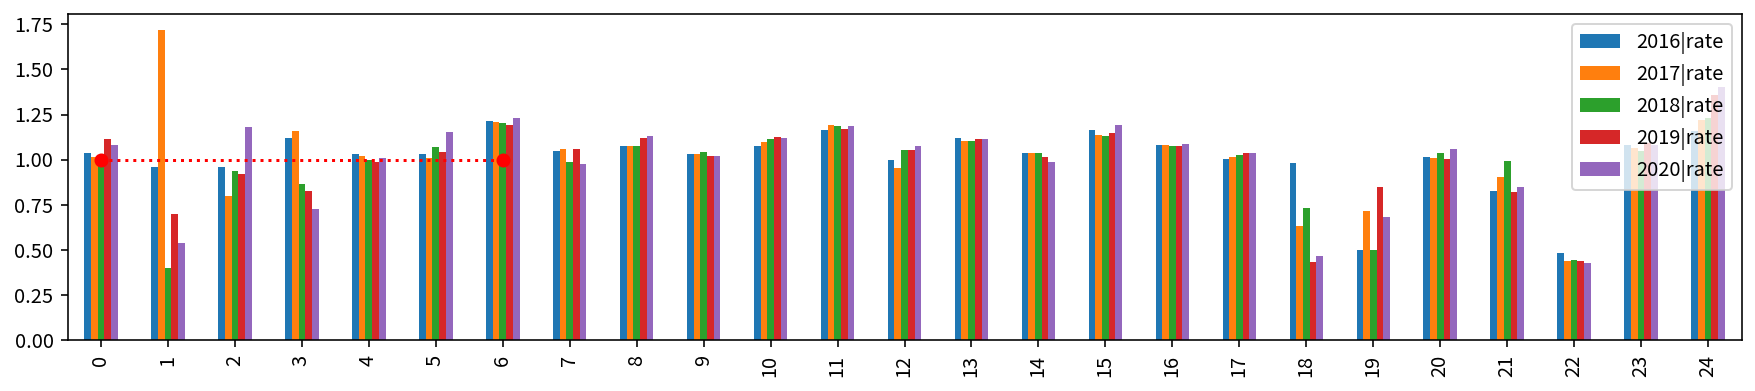

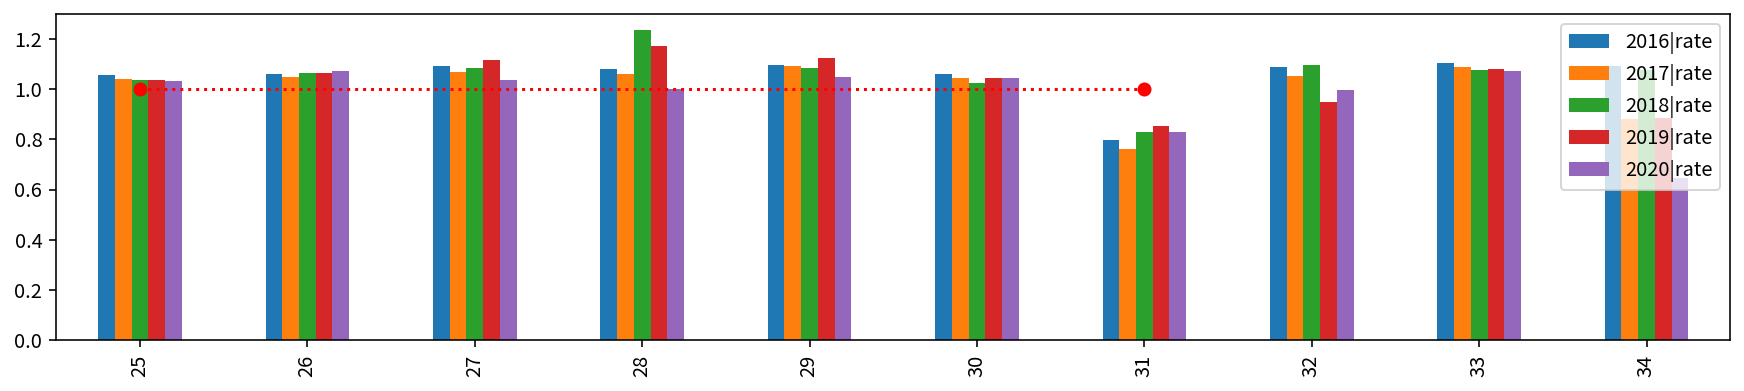

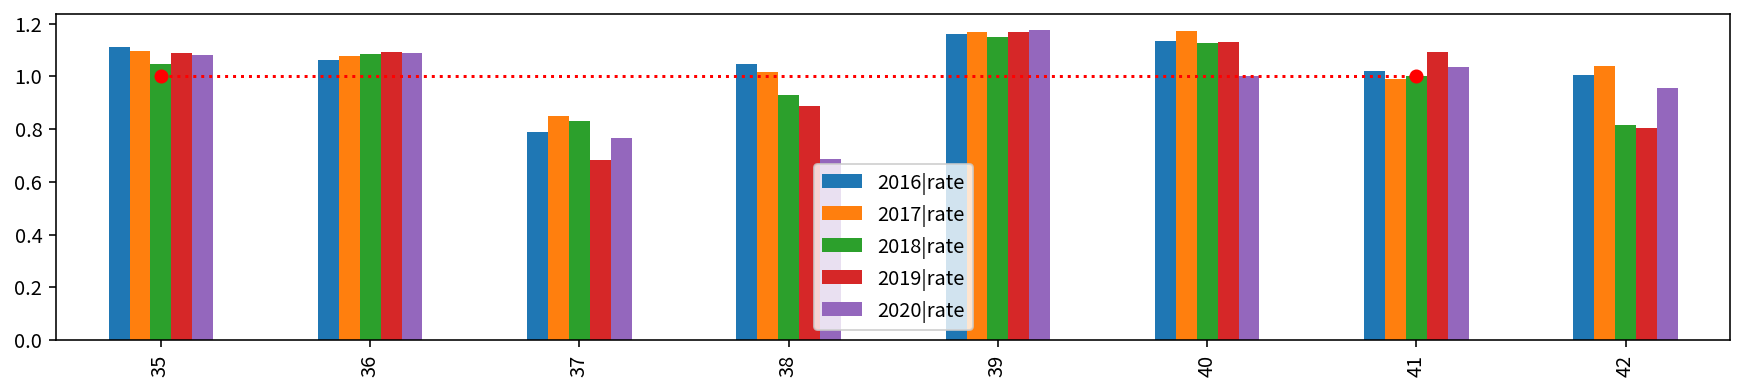

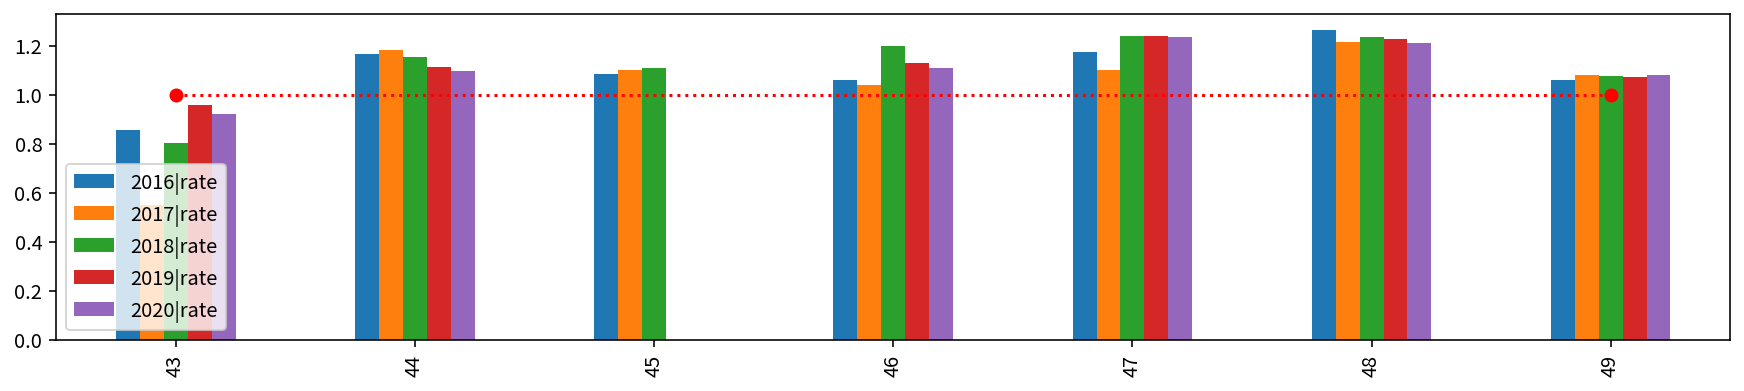

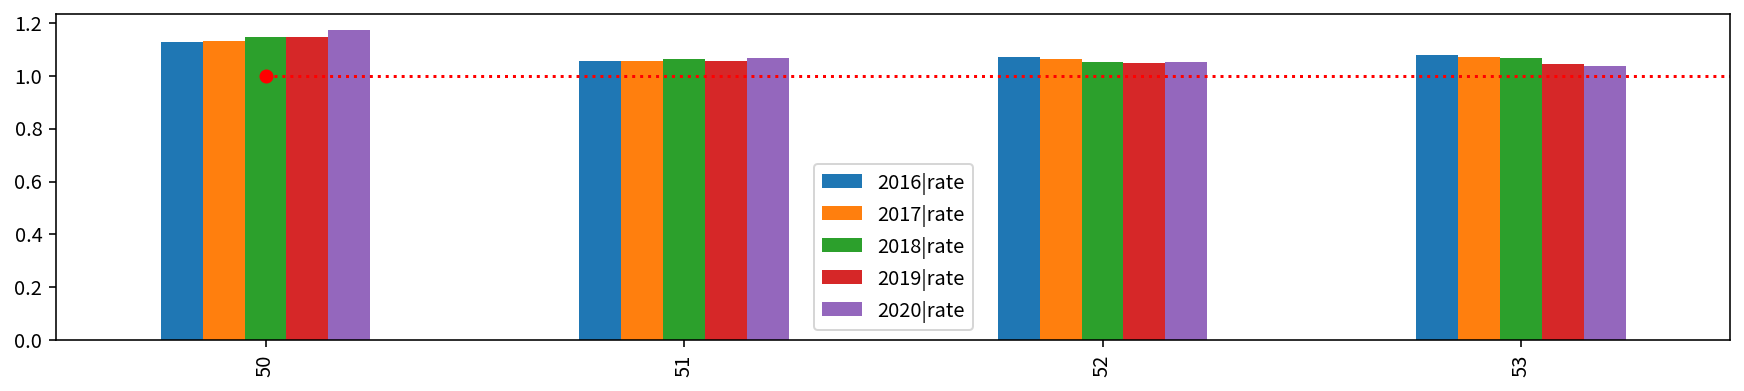

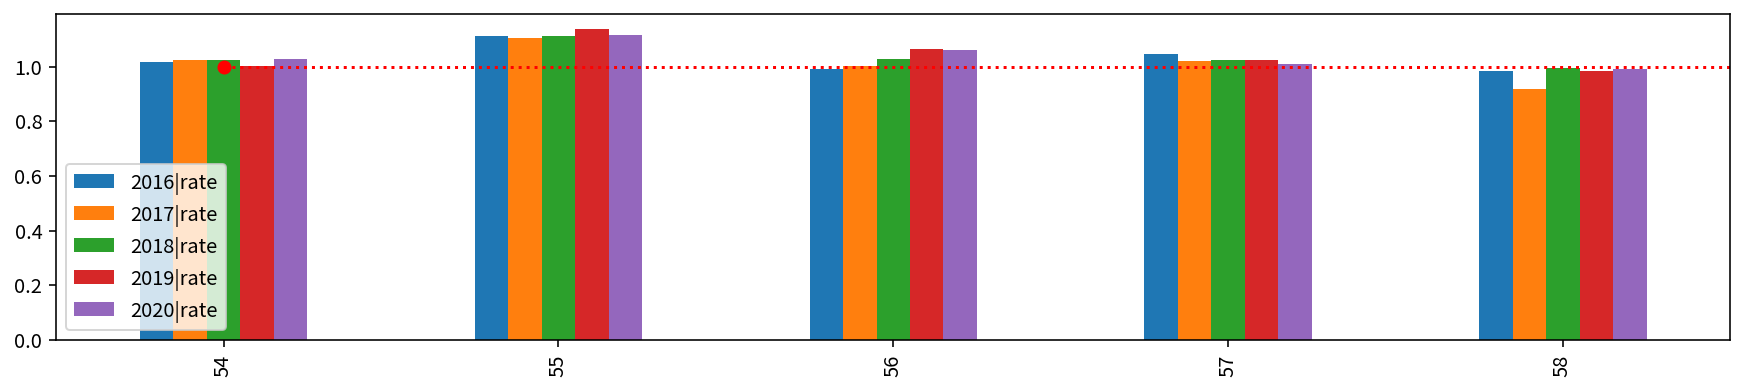

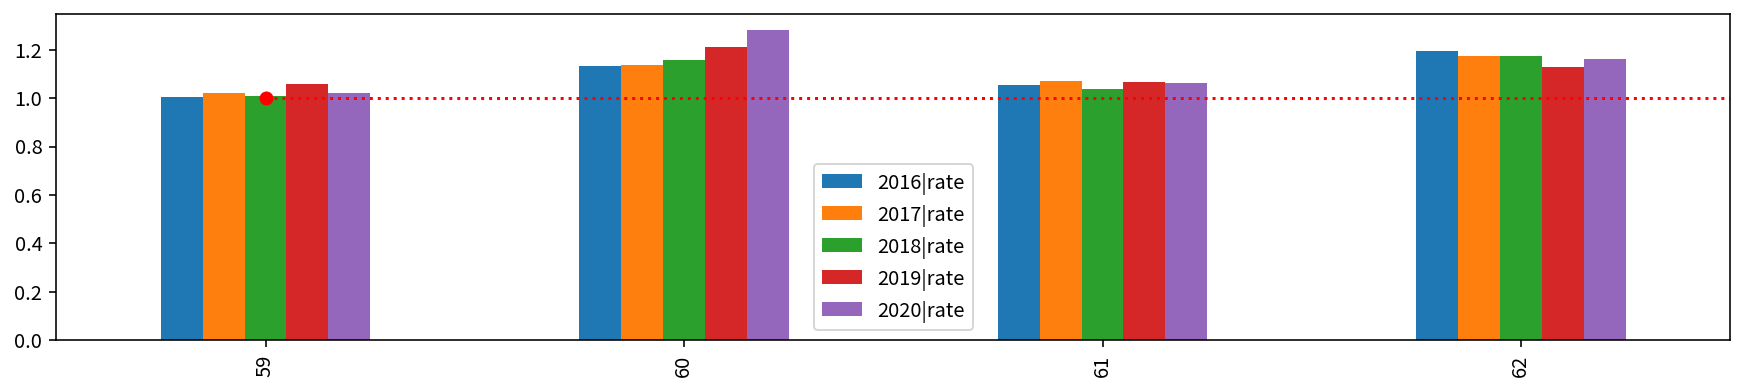

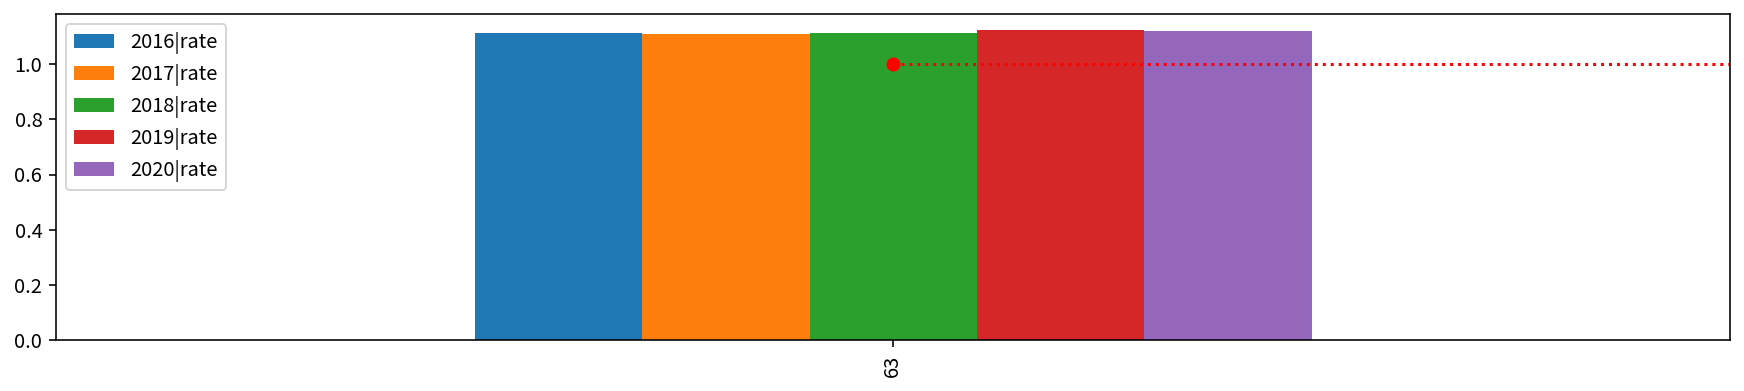

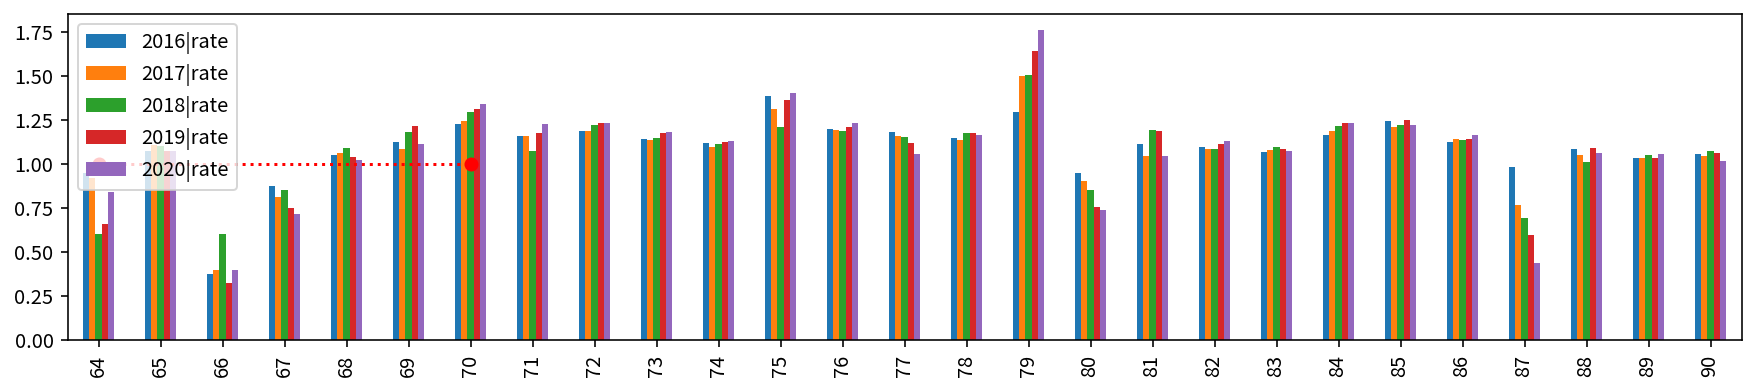

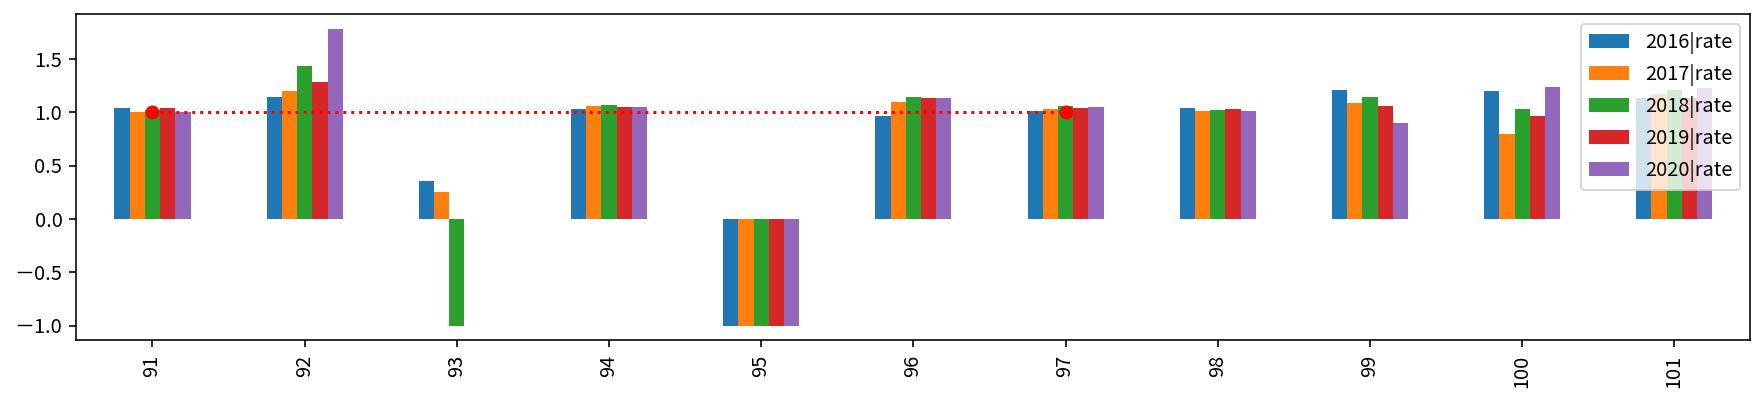

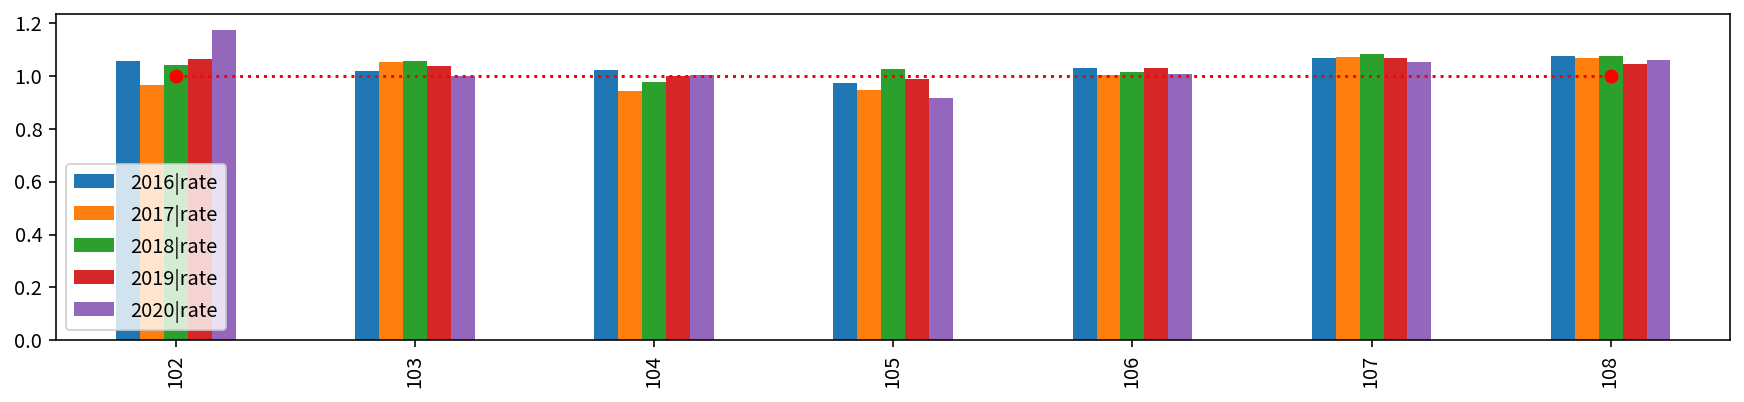

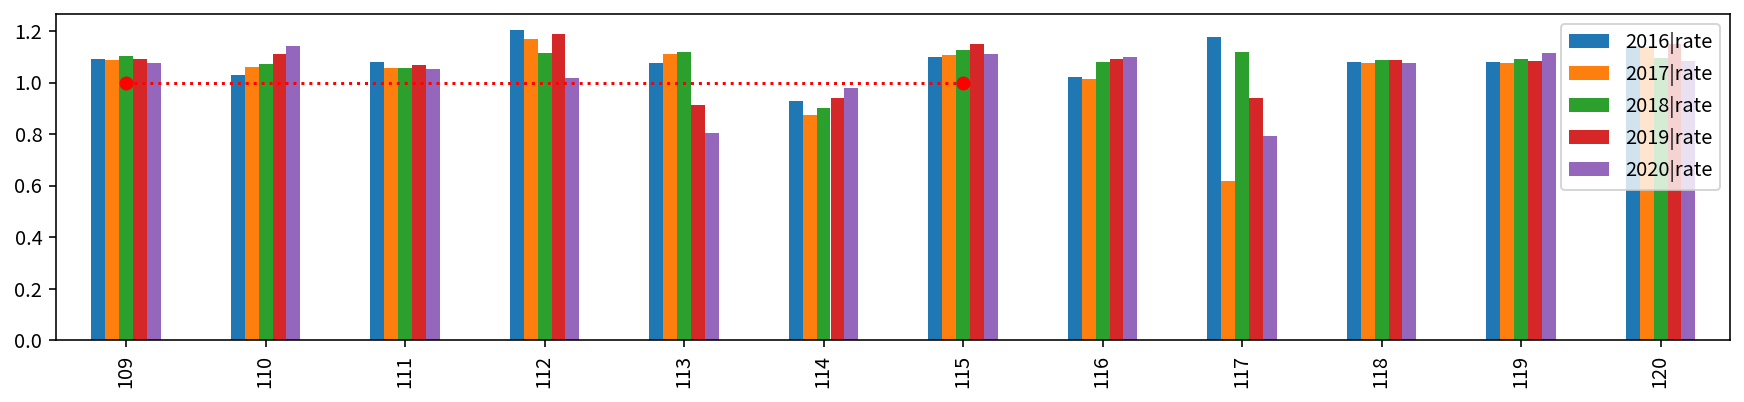

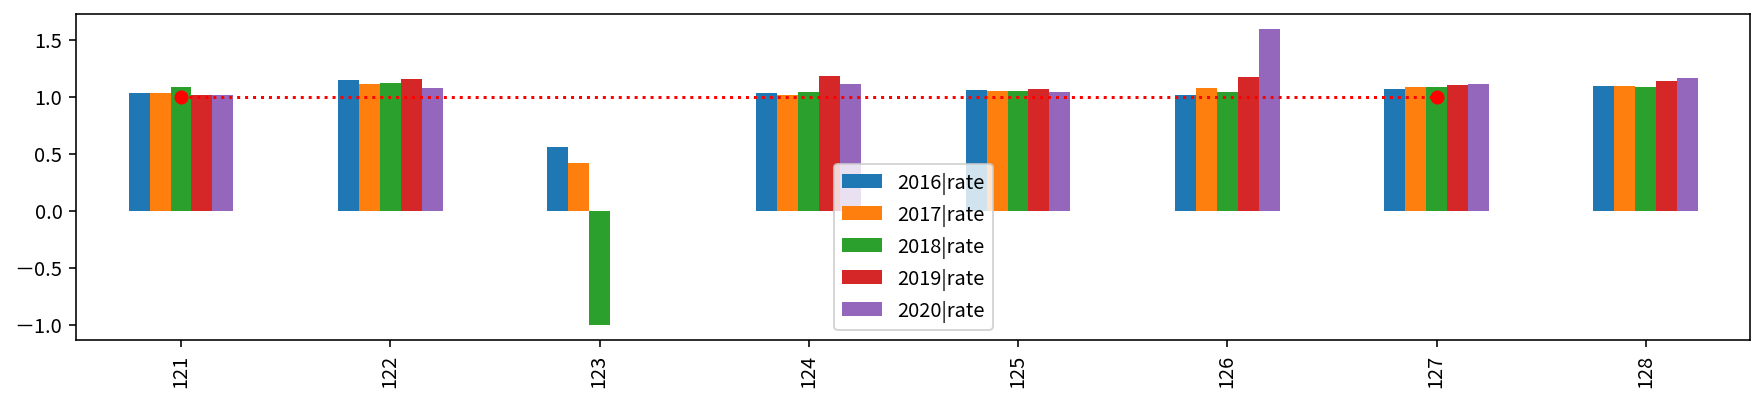

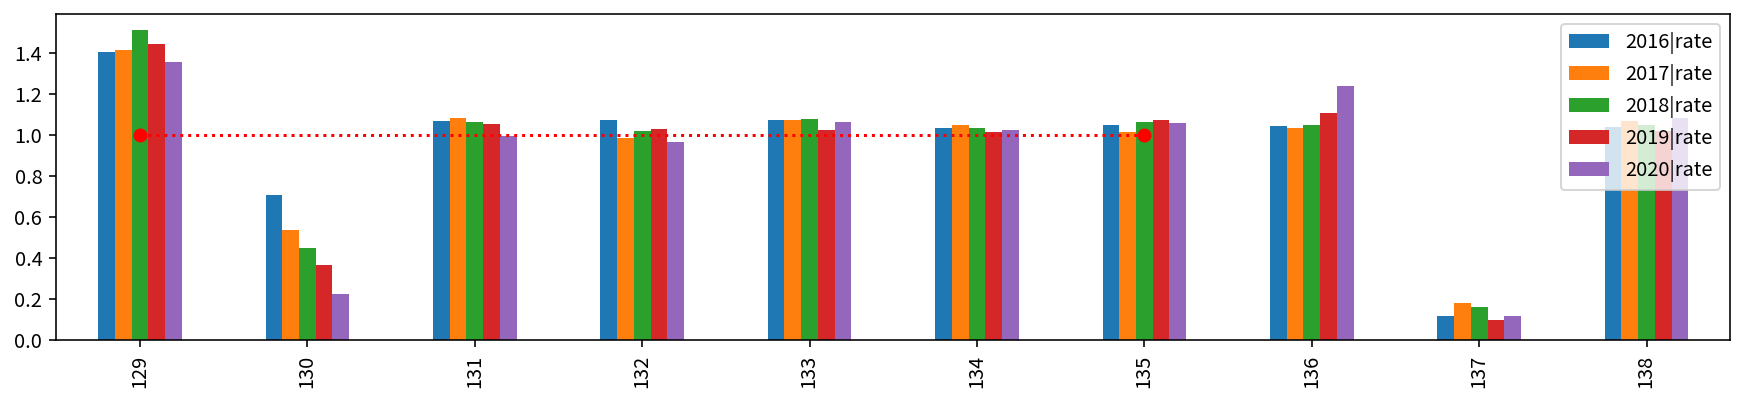

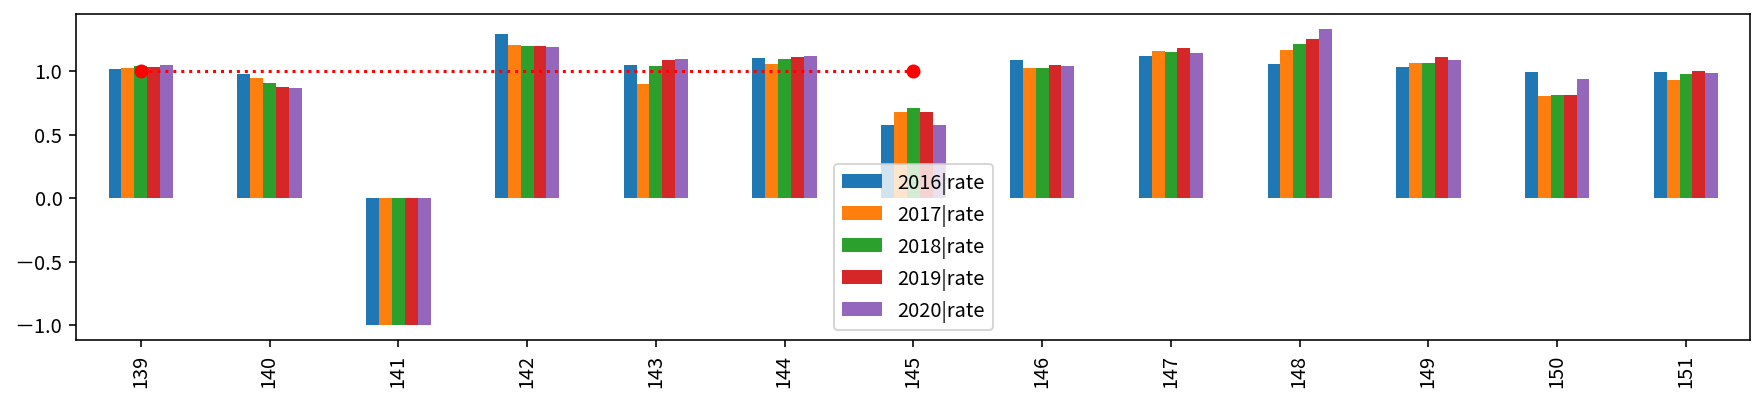

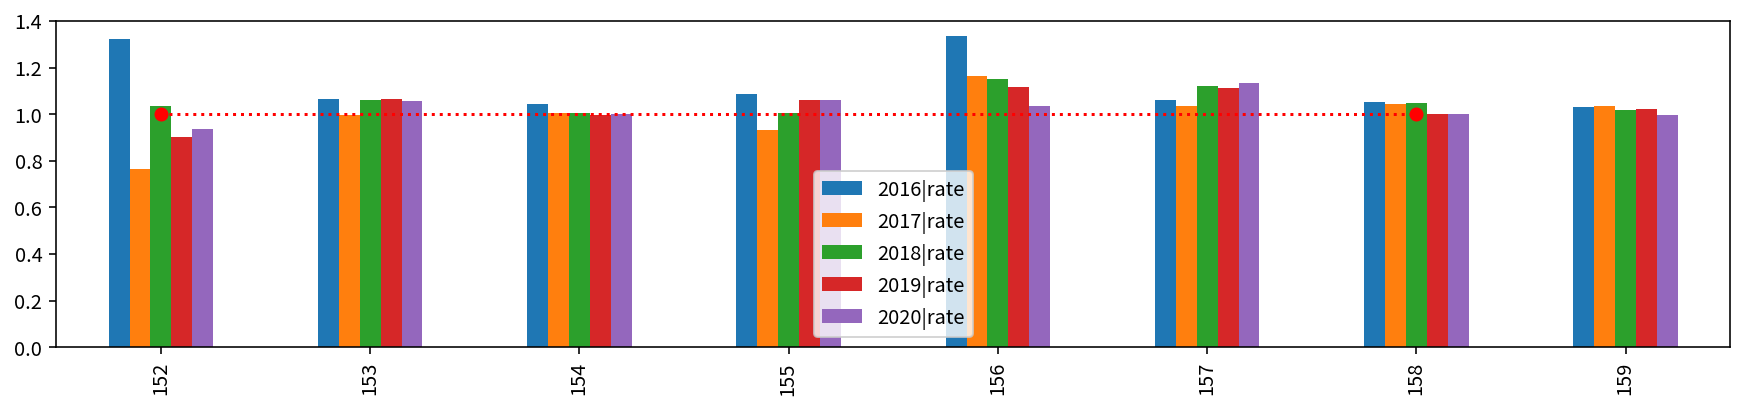

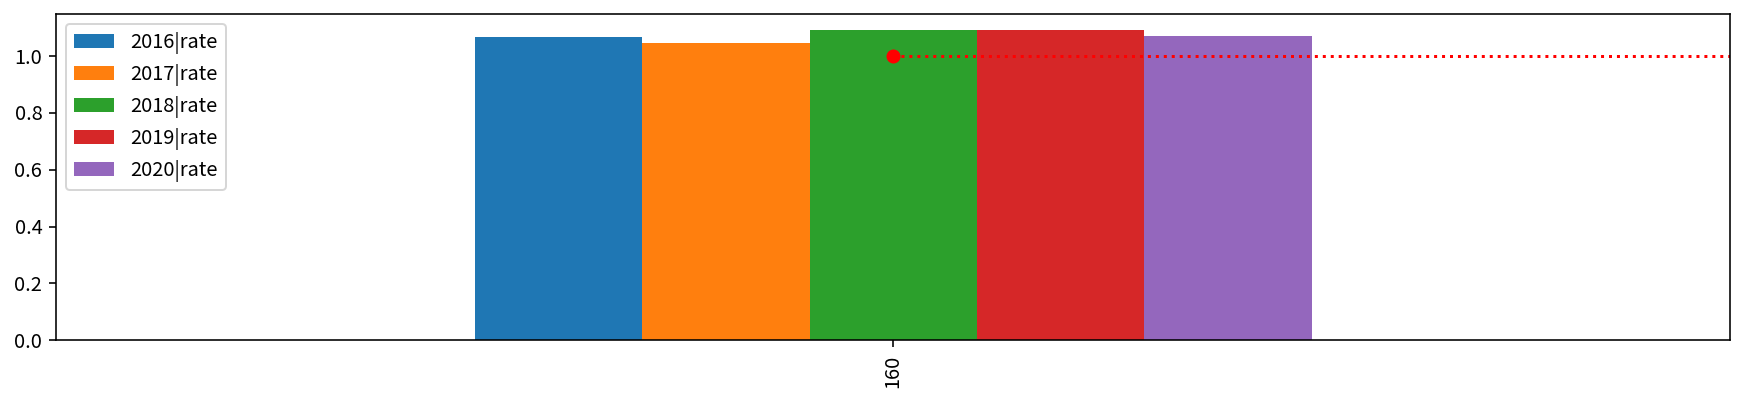

In [27]:
for isido in sido_list:
    df[df['시도']==isido][[
    '2016|rate','2017|rate',
    '2018|rate','2019|rate',
    '2020|rate']].plot.bar(figsize=(15,3), )
    plt.plot([0,6], [1,1], marker = 'o', linestyle=':', color='red' )
    plt.show()